# Performance comparison

In [1]:
%matplotlib inline

try:
    from geosnap import datasets
except:
    print("Geosnap not installed, will have to source some datasets elsewhere")
import geopandas
import pandas
import esda
import pygeoda
import os
import libpysal as ps
from time import time

PERMS = 9999

from libpysal.examples import get_path, load_example

Geosnap not installed, will have to source some datasets elsewhere


## Data

In [2]:
%%time
from geosnap.io import store_census
store_census()

Copying: 0.00B [00:00, ?B/s]
Copying: 0.00B [00:00, ?B/s]

CPU times: user 904 ms, sys: 165 ms, total: 1.07 s
Wall time: 10 s


- Counties

In [2]:
_ = load_example("NCOVR")

counties = geopandas.read_file(get_path("NAT.shp"))
w_counties = ps.weights.Queen.from_dataframe(counties)

- Tracts

In [3]:
%%time
try:
    tracts = geopandas.read_file("tracts.gpkg")
except:
    tracts = datasets.tracts_2010()\
                     [["geoid", "median_household_income", "geometry"]]\
                     .dropna()

CPU times: user 3.58 s, sys: 201 ms, total: 3.79 s
Wall time: 3.75 s


In [4]:
%%time
w_tracts = ps.weights.Queen.from_dataframe(tracts)

CPU times: user 39.3 s, sys: 723 ms, total: 40 s
Wall time: 40 s


/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 37 disconnected components.
 There are 16 islands with ids: 20, 50, 52, 24654, 35292, 36380, 41050, 41070, 43397, 45974, 48067, 48586, 48788, 63773, 68790, 70510.
  warnings.warn(message)


Remove islands:

In [40]:
tracts_noi = tracts[~tracts.index.isin(w_tracts.islands)]

In [43]:
w_tracts_noi = ps.weights.w_subset(w_tracts, tracts_noi.index.tolist())

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 21 disconnected components.
  warnings.warn(message)


In [44]:
w_tracts_noi.islands

[]

## Setup

In [58]:
def workbench(
    db, 
    y_name, 
    w, 
    perms=PERMS, 
    runs=5, 
    save_last=False,
    no_numba=True,
    numba_single=True,
    numba_multi=True,
    geoda=True
):
    print(f"Workbench working on a {os.cpu_count()}-core machine")
    times = {}
    if no_numba:
        times["No Numba"] = []
    if numba_single:
        times["Numba - Single Thread"] = []
    if numba_multi:
        times["Numba - Multi Thread"] = []
    if geoda:
        times["PyGeoda"] = []
    # Ensure function is compiled
    if numba_single:
        one = esda.Moran_Local(db[y_name], 
                               w, 
                               permutations=1,
                               numba=True,
                               n_jobs=1
                              )
    if numba_multi:
        one = esda.Moran_Local(db[y_name], 
                               w, 
                               permutations=1,
                               numba=True,
                               n_jobs=-1
                              )
    # PyGeoda setup
    if geoda:
        db.to_file("tmp")
        db_geoda = pygeoda.open("tmp/tmp.shp")
        y_geoda = db_geoda.GetIntegerCol(y_name)
        w_geoda = pygeoda.weights.queen(db_geoda)
    for i in range(runs):
        # Pre-numba
        if no_numba:
            t0 = time()
            old = esda.Moran_Local(db[y_name], 
                                   w, 
                                   permutations=perms
                                  )
            t1 = time()
            times["No Numba"].append(t1-t0)
        # Numba single thread
        if numba_single:
            t0 = time()
            one = esda.Moran_Local(db[y_name], 
                                   w, 
                                   permutations=perms,
                                   numba=True,
                                   n_jobs=1
                                  )
            t1 = time()
            times["Numba - Single Thread"].append(t1-t0)
        # Numba multi thread
        if numba_multi:
            t0 = time()
            mul = esda.Moran_Local(db[y_name], 
                                   w, 
                                   permutations=perms,
                                   numba=True,
                                   n_jobs=-1
                                  )
            t1 = time()
            times["Numba - Multi Thread"].append(t1-t0)
        # PyGeoDa
        if geoda:
            lisa_geoda = pygeoda.local_moran(w_geoda, y_geoda)
            lisa_geoda.SetPermutations(perms)
            t0 = time()
            lisa_geoda.Run()
            t1 = time()
            times["PyGeoda"].append(t1-t0)
    if save_last:
        last = {}
        if no_numba:
            last["No Numba"] = old.p_sim
        if numba_single:
            last["Numba - Single Thread"] = one.p_sim
        if numba_multi:
            last["Numba - Multi Thread"] = mul.p_sim
        if geoda:
            last["PyGeoda"] = lisa_geoda.GetPValues()
        pvals = pandas.DataFrame(last)
    else:
        pvals = None
    if geoda:
        os.system("rm -rf tmp")
    return pandas.DataFrame(times), pvals

## All counties

In [53]:
%%time
res_counties = workbench(counties, 
                         "HR70", 
                         w_counties, 
                         perms=9999, 
                         runs=7,
                         save_last=True
                        )
timing_counties, pvals_counties = res_counties

Workbench working on a 8-core machine
CPU times: user 2min 38s, sys: 2.84 s, total: 2min 41s
Wall time: 56.1 s


In [54]:
timing_counties.mean()

No Numba                 3.511575
Numba - Single Thread    1.073173
Numba - Multi Thread     0.568531
PyGeoda                  1.108585
dtype: float64

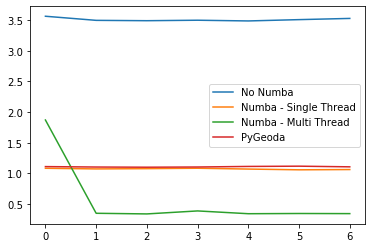

In [55]:
timing_counties.plot()

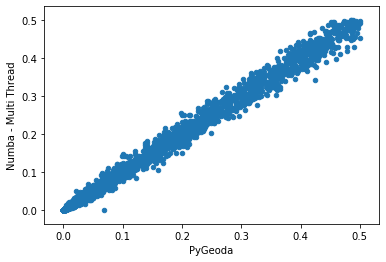

In [56]:
pvals_counties.plot.scatter("PyGeoda", "Numba - Multi Thread")

## All tracts

In [47]:
%%time
timing_tracts, pvals_tracts = workbench(tracts_noi, 
                                        "median_household_income", 
                                        w_tracts_noi, 
                                        perms=9999, 
                                        runs=3,
                                        save_last=True
                                       )

Workbench working on a 8-core machine


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 47min 7s, sys: 52 s, total: 47min 59s
Wall time: 17min 18s


In [48]:
timing_tracts.mean()

No Numba                 209.010330
Numba - Single Thread     51.135469
Numba - Multi Thread      26.789729
PyGeoda                   40.246421
dtype: float64

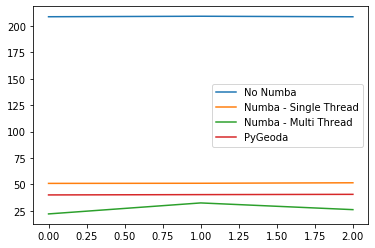

In [49]:
timing_tracts.plot()

In [52]:
pvals_tracts.head()

,No Numba,Numba - Single Thread,Numba - Multi Thread,PyGeoda
0,0.2642,0.2629,0.2585,0.0001
1,0.0902,0.0887,0.0884,0.0001
2,0.0097,0.0132,0.0139,0.0001
3,0.3574,0.3575,0.3550,0.0001
4,0.2453,0.2459,0.2340,0.0001


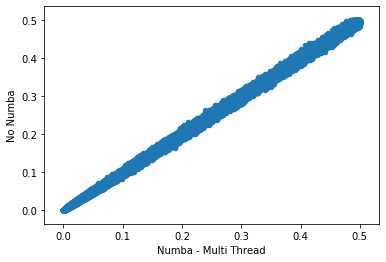

In [51]:
pvals_tracts.plot.scatter("Numba - Multi Thread", "No Numba")

---

In [ ]:
%%time
timing_tracts, pvals_tracts = workbench(tracts_noi, 
                                        "median_household_income", 
                                        w_tracts_noi, 
                                        perms=99999, 
                                        runs=3,
                                        save_last=True,
                                        no_numba=False
                                       )

Workbench working on a 8-core machine


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [64]:
timing_tracts.mean()

Numba - Single Thread    427.269421
Numba - Multi Thread     248.592175
PyGeoda                  441.695828
dtype: float64

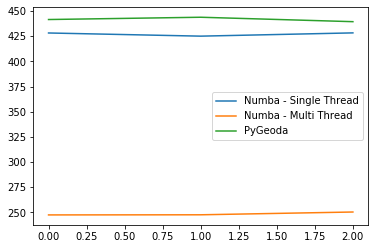

In [66]:
timing_tracts.plot()

## All blocks